In [187]:
import os
import tkinter as tk
from tkinter.colorchooser import askcolor
from tkinter.simpledialog import askstring
from PIL import Image, ImageDraw

class PaintApp:
    def __init__(self, root, canvas_size=(28, 28), scale=5):
        self.root = root
        self.root.title("Simple Paint App")
        
        # Scale settings
        self.canvas_size = canvas_size
        self.scale = scale
        self.display_size = (canvas_size[0] * scale, canvas_size[1] * scale)

        # Default settings
        self.brush_color = "black"
        self.brush_size = 20  # This is the display brush size

        # Set up Canvas
        self.canvas = tk.Canvas(root, bg="white", width=self.display_size[0], height=self.display_size[1])
        self.canvas.pack()

        # Set up PIL image to draw on and save later (true 28x28 resolution)
        self.image = Image.new("RGB", self.canvas_size, "white")
        self.draw = ImageDraw.Draw(self.image)

        # Canvas bindings
        self.canvas.bind("<B1-Motion>", self.paint)
        self.canvas.bind("<Button-1>", self.paint)  # Allow single clicks to paint
        
        # Set up UI for color and brush size
        self.setup_ui()

    def setup_ui(self):
        # Label input
        self.label_button = tk.Button(self.root, text="Set Label", command=self.set_label)
        self.label_button.pack(side="left")

        # Color button
        color_button = tk.Button(self.root, text="Choose Color", command=self.choose_color)
        color_button.pack(side="left")

        # Clear button
        clear_button = tk.Button(self.root, text="Clear", command=self.clear_canvas)
        clear_button.pack(side="left")

        # Save button
        save_button = tk.Button(self.root, text="Save", command=self.save_image)
        save_button.pack(side="left")

        # Default label
        self.label = "image"

    def set_label(self):
        label = askstring("Set Label", "Enter label for image filename:")
        if label:
            self.label = label
            print(f"Label set to '{self.label}'")

    def choose_color(self):
        color = askcolor(color=self.brush_color)[1]
        if color:
            self.brush_color = color

    def paint(self, event):
        # Calculate scaled-down coordinates for the 28x28 image
        scaled_x, scaled_y = int(event.x / self.scale), int(event.y / self.scale)

        # Draw on the displayed canvas (scaled-up, with ovals)
        x, y = event.x, event.y
        r = self.brush_size / 2
        self.canvas.create_oval(x - r, y - r, x + r, y + r, fill=self.brush_color, outline="")

        # Draw a smaller oval on the 28x28 PIL image to represent the scaled effect
        scaled_r = max(1, int(r / self.scale))  # Ensure the brush size is at least 1 in the 28x28 scale
        self.draw.ellipse([scaled_x - scaled_r, scaled_y - scaled_r, scaled_x + scaled_r, scaled_y + scaled_r], fill=self.brush_color)

    def clear_canvas(self):
        # Clear the tkinter canvas
        self.canvas.delete("all")
        # Clear the 28x28 PIL image
        self.draw.rectangle([0, 0, *self.canvas_size], fill="white")

    def save_image(self):
        # Save the 28x28 image with the specified label
        img_number = 1
        filename = f"data/{self.label}_{img_number}.png"
        
        # Ensure filename is unique
        while os.path.exists(filename):
            img_number += 1
            filename = f"data/{self.label}_{img_number}.png"
        
        # Make directory if it doesn't exist
        os.makedirs("data", exist_ok=True)

        self.image.save(filename)
        print(f"Image saved as {filename}")

        self.clear_canvas()

# Run the application
root = tk.Tk()
app = PaintApp(root)
root.mainloop()


Label set to '0'
Image saved as data/0_48.png
Image saved as data/0_49.png
Image saved as data/0_50.png
Image saved as data/0_51.png
Image saved as data/0_52.png
Image saved as data/0_53.png
Image saved as data/0_54.png
Image saved as data/0_55.png
Image saved as data/0_56.png
Image saved as data/0_57.png
Image saved as data/0_58.png
Image saved as data/0_59.png
Image saved as data/0_60.png
Image saved as data/0_61.png
Image saved as data/0_62.png
Image saved as data/0_63.png
Image saved as data/0_64.png
Image saved as data/0_65.png
Image saved as data/0_66.png


X shape: (251, 784)
y shape: (251,)
Training data shape: (200, 784)
Testing data shape: (51, 784)
0.7843137254901961


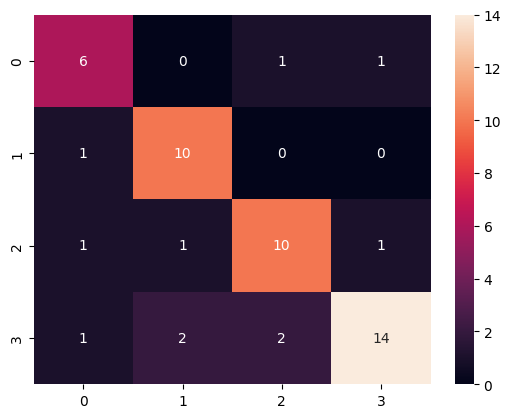

Correct predictions:


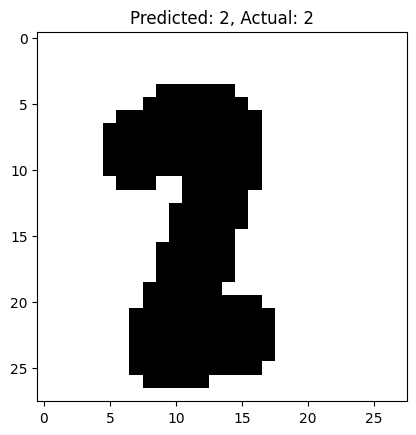

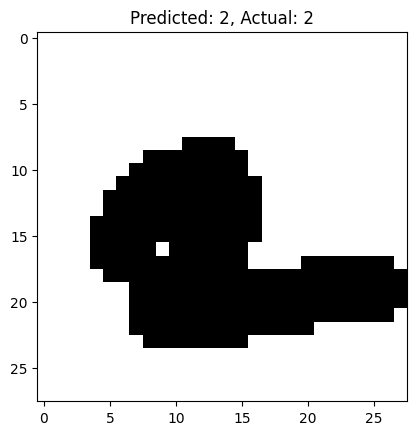

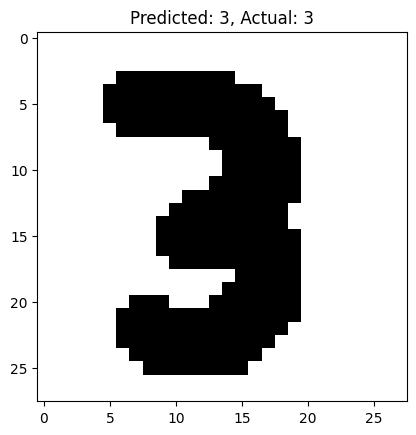

Incorrect predictions:


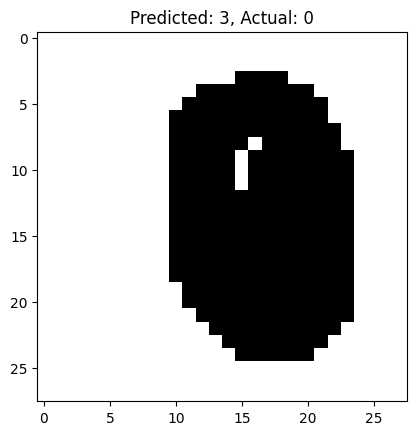

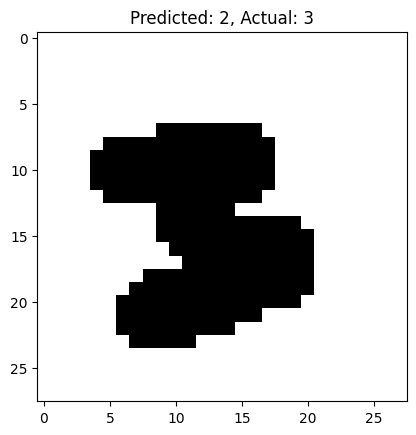

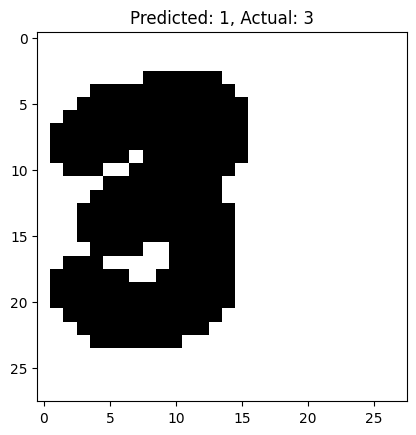

In [200]:
# load in digit pngs (labeld as 0_1, 0_2, 0_3.png etc where the first is the label) of 32x32 pixels and convert them to 1D numpy arrays

import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import random

def load_data():
    data = []
    labels = []
    for file in os.listdir("data"):
        if file.endswith(".png"):
            img = Image.open("data/" + file)
            img = img.convert("L")
            img = img.resize((28, 28))
            img = np.array(img)
            img = img.flatten()
            data.append(img)
            labels.append(int(file.split("_")[0]))
    data = np.array(data)
    labels = np.array(labels)
    return data, labels

data, labels = load_data()

print("X shape:", data.shape)
print("y shape:", labels.shape)

# Create sklearn neural network to classify the digits
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

X_train_custom, X_test_custom, y_train_custom, y_test_custom = train_test_split(data, labels, test_size=0.2)

print("Training data shape:", X_train_custom.shape)
print("Testing data shape:", X_test_custom.shape)

clf = MLPClassifier(hidden_layer_sizes=(128,), max_iter=1000)
clf.fit(X_train_custom, y_train_custom)

print(clf.score(X_test_custom, y_test_custom))

# Show confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred_custom = clf.predict(X_test_custom)
cm = confusion_matrix(y_test_custom, y_pred_custom)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

print("Correct predictions:")

# Show some correct predictions and the actual images and label
correct = 0
attempts = 0
while correct < 3 and attempts < 100:
    index = random.randint(0, len(X_test_custom) - 1)
    pred = clf.predict([X_test_custom[index]])
    if pred == y_test_custom[index]:
        correct += 1
        img = X_test_custom[index].reshape(28, 28)
        plt.imshow(img, cmap="gray")
        plt.title(f"Predicted: {pred[0]}, Actual: {y_test_custom[index]}")
        plt.show()

print("Incorrect predictions:")

# Show some incorrect predictions and the actual images and label
incorrect = 0
attempts = 0
while incorrect < 3 and attempts < 100:
    index = random.randint(0, len(X_test_custom) - 1)
    pred = clf.predict([X_test_custom[index]])
    if pred != y_test_custom[index]:
        incorrect += 1
        img = X_test_custom[index].reshape(28, 28)
        plt.imshow(img, cmap="gray")
        plt.title(f"Predicted: {pred[0]}, Actual: {y_test_custom[index]}")
        plt.show()
